In [1]:
from sklearn.datasets import load_files
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
import seaborn as sns

### Q1 Text pre-processing and exploration<br>

#### 1.2 Split to train and test

In [2]:
train_path = r"C:\Users\zvikf\Desktop\ohsumed-first-20000-docs.tar\ohsumed-first-20000-docs\training"
test_path = r"C:\Users\zvikf\Desktop\ohsumed-first-20000-docs.tar\ohsumed-first-20000-docs\test"
train_data = load_files(train_path, encoding='UTF-8')
test_data = load_files(test_path, encoding='UTF-8')
targets = ['Bacterial Infections and Mycoses',                      
'Virus Diseases',                                        
'Parasitic Diseases',                                    
'Neoplasms',                                             
'Musculoskeletal Diseases',                              
'Digestive System Diseases',                             
'Stomatognathic Diseases',                               
'Respiratory Tract Diseases',                            
'Otorhinolaryngologic Diseases',                         
'Nervous System Diseases',                               
'Eye Diseases',                                          
'Urologic and Male Genital Diseases',                    
'Female Genital Diseases and Pregnancy Complications',   
'Cardiovascular Diseases',                               
'Hemic and Lymphatic Diseases',                          
'Neonatal Diseases and Abnormalities',                   
'Skin and Connective Tissue Diseases',                   
'Nutritional and Metabolic Diseases',                    
'Endocrine Diseases',                                    
'Immunologic Diseases',                                  
'Disorders of Environmental Origin',                     
'Animal Diseases',                                       
'Pathological Conditions, Signs and Symptoms']

#### 1.3 We will clean and normalize the text according to the next actions:
1. tokenization.
2. lower case. 
3. stop words removal.
4. stemming.

tokenizing + lowering of every phrase

In [3]:
tr_tknzd_data = [word_tokenize(phrase.lower()) for phrase in train_data['data']]
te_tknzd_data = [word_tokenize(phrase.lower()) for phrase in test_data['data']]


Removing stop words and punctuation

In [4]:
# new set of stop words and punctuation for easy use in lambda expr
stop_and_punctuation = set(stopwords.words('english')).union(punctuation)
not_stop_punct = lambda word: word not in stop_and_punctuation
no_stops_train = [list(filter(not_stop_punct, phrase)) for phrase in tr_tknzd_data]
no_stops_test = [list(filter(not_stop_punct, phrase)) for phrase in te_tknzd_data]

And the last pre processing step - stemming

In [5]:
ps = PorterStemmer()
stemmed_train = [[ps.stem(word) for word in phrase] for phrase in no_stops_train]
stemmed_test = [[ps.stem(word) for word in phrase] for phrase in no_stops_test]

#### Q1.4 Now, we will do some exploration.<br>
First, this are the categories.

Bacterial Infections and Mycoses                      C01<br>
Virus Diseases                                        C02<br>
Parasitic Diseases                                    C03<br>
Neoplasms                                             C04<br>
Musculoskeletal Diseases                              C05<br>
Digestive System Diseases                             C06<br>
Stomatognathic Diseases                               C07<br>
Respiratory Tract Diseases                            C08<br>
Otorhinolaryngologic Diseases                         C09<br>
Nervous System Diseases                               C10<br>
Eye Diseases                                          C11<br>
Urologic and Male Genital Diseases                    C12<br>
Female Genital Diseases and Pregnancy Complications   C13<br>
Cardiovascular Diseases                               C14<br>
Hemic and Lymphatic Diseases                          C15<br>
Neonatal Diseases and Abnormalities                   C16<br>
Skin and Connective Tissue Diseases                   C17<br>
Nutritional and Metabolic Diseases                    C18<br>
Endocrine Diseases                                    C19<br>
Immunologic Diseases                                  C20<br>
Disorders of Environmental Origin                     C21<br>
Animal Diseases                                       C22<br>
Pathological Conditions, Signs and Symptoms           C23<br>

We will present number of docs per category by re-grouping docs by their category.<br>
Btw, train_data['target'] returns index of a category so the defined 'targets' list (above) will return the category real name by index.

In [6]:
category_to_doc = dict()
for i in range(len(stemmed_train)):
    category = targets[train_data['target'][i]]  #t
    if category in category_to_doc:
        category_to_doc[category].append(stemmed_train[i])
    else:
        category_to_doc[category] = [stemmed_train[i]]

In [7]:
category_to_count = {cat:[len(docs)] for cat,docs in category_to_doc.items()}
category_to_count = pd.DataFrame.from_dict(category_to_count)
category_to_count

,Endocrine Diseases,Immunologic Diseases,Cardiovascular Diseases,Disorders of Environmental Origin,"Pathological Conditions, Signs and Symptoms",Virus Diseases,Stomatognathic Diseases,Nutritional and Metabolic Diseases,Neoplasms,Female Genital Diseases and Pregnancy Complications,...,Neonatal Diseases and Abnormalities,Otorhinolaryngologic Diseases,Bacterial Infections and Mycoses,Respiratory Tract Diseases,Parasitic Diseases,Musculoskeletal Diseases,Urologic and Male Genital Diseases,Eye Diseases,Hemic and Lymphatic Diseases,Digestive System Diseases
0,191,525,1249,546,1799,158,100,388,1163,281,...,200,125,423,473,65,283,491,162,215,588


Same with histogram

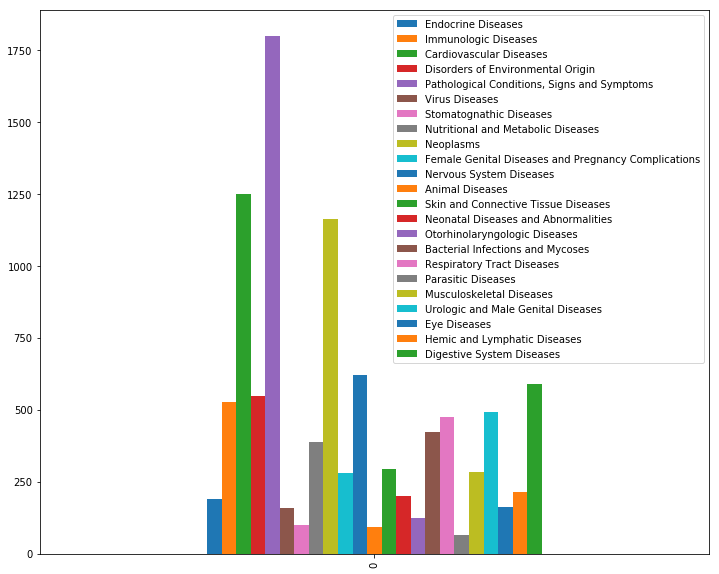

In [8]:
category_to_count.plot(kind='bar',figsize=(12,10))

Let's see the table of top 10 words per category.

In [9]:
def docs_counter(docs):
    all_docs = []
    for doc in docs:
        all_docs += doc
    return Counter(all_docs)
top = 10
category_top10 = {cat:docs_counter(docs).most_common(top) for cat,docs in category_to_doc.items()}

In [10]:
category_top10_df = pd.DataFrame.from_dict(category_top10)
category_top10_df

,Endocrine Diseases,Immunologic Diseases,Cardiovascular Diseases,Disorders of Environmental Origin,"Pathological Conditions, Signs and Symptoms",Virus Diseases,Stomatognathic Diseases,Nutritional and Metabolic Diseases,Neoplasms,Female Genital Diseases and Pregnancy Complications,...,Neonatal Diseases and Abnormalities,Otorhinolaryngologic Diseases,Bacterial Infections and Mycoses,Respiratory Tract Diseases,Parasitic Diseases,Musculoskeletal Diseases,Urologic and Male Genital Diseases,Eye Diseases,Hemic and Lymphatic Diseases,Digestive System Diseases
0,"(patient, 568)","(patient, 1275)","(patient, 3831)","(patient, 1083)","(patient, 4887)","(patient, 287)","(patient, 151)","(patient, 744)","(patient, 2886)","(patient, 416)",...,"(patient, 471)","(patient, 229)","(patient, 973)","(patient, 1172)","(patient, 111)","(patient, 585)","(patient, 1317)","(patient, 314)","(patient, 610)","(patient, 1886)"
1,"(diabet, 264)","(infect, 601)","(+/-, 1344)","(injuri, 589)","(group, 1207)","(infect, 274)","(cell, 64)","(diabet, 716)","(cell, 1614)","(pregnanc, 321)",...,"(group, 142)","(ear, 81)","(infect, 634)","(lung, 465)","(infect, 92)","(bone, 214)","(renal, 569)","(eye, 176)","(cell, 242)","(diseas, 539)"
2,"(+/-, 192)","(cell, 552)","(arteri, 1273)","(use, 375)","(studi, 1043)","(viru, 180)","(periodont, 59)","(+/-, 431)","(tumor, 1450)","(women, 317)",...,"(studi, 141)","(use, 75)","(treatment, 265)","(pulmonari, 420)","(diseas, 46)","(studi, 158)","(studi, 304)","(retin, 132)","(diseas, 161)","(studi, 404)"
3,"(level, 155)","(diseas, 388)","(group, 1096)","(alcohol, 346)","(use, 1019)","(human, 139)","(treatment, 57)","(glucos, 412)","(cancer, 1000)","(infect, 176)",...,"(arteri, 135)","(case, 69)","(group, 258)","(group, 314)","(parasit, 44)","(use, 146)","(treatment, 304)","(use, 87)","(studi, 129)","(group, 322)"
4,"(thyroid, 148)","(hiv, 360)","(coronari, 1053)","(studi, 330)","(less, 861)","(cell, 113)","(case, 55)","(insulin, 397)","(carcinoma, 904)","(use, 171)",...,"(infant, 134)","(studi, 65)","(case, 244)","(studi, 297)","(studi, 43)","(result, 138)","(prostat, 303)","(case, 79)","(case, 127)","(less, 313)"
5,"(studi, 146)","(studi, 345)","(less, 1039)","(result, 264)","(case, 830)","(immunodefici, 101)","(tumor, 47)","(studi, 328)","(case, 700)","(group, 167)",...,"(ventricular, 119)","(group, 64)","(diseas, 240)","(diseas, 289)","(case, 42)","(case, 127)","(use, 268)","(diseas, 74)","(increas, 113)","(p, 294)"
6,"(less, 146)","(human, 328)","(p, 1001)","(fractur, 245)","(diseas, 789)","(diseas, 98)","(use, 47)","(level, 327)","(studi, 695)","(studi, 147)",...,"(pulmonari, 110)","(diseas, 61)","(use, 210)","(p, 271)","(day, 33)","(group, 119)","(diseas, 262)","(visual, 73)","(syndrom, 110)","(use, 277)"
7,"(glucos, 136)","(use, 310)","(ventricular, 898)","(case, 242)","(result, 781)","(studi, 88)","(diseas, 43)","(increas, 322)","(use, 619)","(diseas, 119)",...,"(use, 107)","(treatment, 56)","(studi, 198)","(less, 264)","(treatment, 33)","(year, 115)","(tumor, 254)","(studi, 73)","(group, 107)","(treatment, 276)"
8,"(diseas, 123)","(immunodefici, 306)","(studi, 876)","(effect, 220)","(p, 773)","(hiv, 87)","(primari, 40)","(less, 309)","(treatment, 566)","(treatment, 118)",...,"(defect, 106)","(nasal, 54)","(clinic, 192)","(use, 250)","(antibodi, 31)","(diseas, 113)","(cell, 254)","(develop, 63)","(p, 103)","(gastric, 261)"
9,"(p, 119)","(aid, 289)","(heart, 874)","(trauma, 217)","(effect, 710)","(case, 83)","(studi, 40)","(control, 294)","(diseas, 550)","(less, 110)",...,"(age, 101)","(result, 53)","(therapi, 178)","(increas, 247)","(control, 28)","(treatment, 113)","(group, 241)","(group, 62)","(may, 94)","(ulcer, 260)"


It looks like the most common word for almost each category is patient.<br>
Let's do some prints 

In [11]:
for cat,tops in category_top10.items():
    word,count = tops[0]
    print(cat + " most common word: " + word)

Endocrine Diseases most common word: patient
Immunologic Diseases most common word: patient
Cardiovascular Diseases most common word: patient
Disorders of Environmental Origin most common word: patient
Pathological Conditions, Signs and Symptoms most common word: patient
Virus Diseases most common word: patient
Stomatognathic Diseases most common word: patient
Nutritional and Metabolic Diseases most common word: patient
Neoplasms most common word: patient
Female Genital Diseases and Pregnancy Complications most common word: patient
Nervous System Diseases most common word: patient
Animal Diseases most common word: model
Skin and Connective Tissue Diseases most common word: patient
Neonatal Diseases and Abnormalities most common word: patient
Otorhinolaryngologic Diseases most common word: patient
Bacterial Infections and Mycoses most common word: patient
Respiratory Tract Diseases most common word: patient
Parasitic Diseases most common word: patient
Musculoskeletal Diseases most commo

Yep, that's true, now let's look on the top-2 and top-3 words ratio between distinct words to all words in the second and thired respectful places.

In [12]:
distinct_words_2 = set()
distinct_words_3 = set()

for _,tops in category_top10.items():
    word2,_ = tops[1] #second place
    word3,_ = tops[2] #thired place
    distinct_words_2.add(word2)
    distinct_words_3.add(word3)
    
number_of_targets = len(set(train_data['target']))
ratio2 = len(distinct_words_2) / number_of_targets
ratio3 = len(distinct_words_3) / number_of_targets

print("Ratio for the second most common place for each category " + str(ratio2))
print("Ratio for the thired most common place for each category " + str(ratio3))                        

Ratio for the second most common place for each category 0.6521739130434783
Ratio for the thired most common place for each category 0.6086956521739131


0.65 and 60 means that 60% of the top words for each category document are same. it will be not easy to classify documents according to the top words and maybe we will need to take them out or to use more features for each document.<br>
Another way to look on this information will be to gather all the top-10 distinct words from above and to present each word and the word related classes.It will be more easy to find overlapping classes depends on these words.

In [13]:
category_top10

{'Endocrine Diseases': [('patient', 568),
  ('diabet', 264),
  ('+/-', 192),
  ('level', 155),
  ('thyroid', 148),
  ('studi', 146),
  ('less', 146),
  ('glucos', 136),
  ('diseas', 123),
  ('p', 119)],
 'Immunologic Diseases': [('patient', 1275),
  ('infect', 601),
  ('cell', 552),
  ('diseas', 388),
  ('hiv', 360),
  ('studi', 345),
  ('human', 328),
  ('use', 310),
  ('immunodefici', 306),
  ('aid', 289)],
 'Cardiovascular Diseases': [('patient', 3831),
  ('+/-', 1344),
  ('arteri', 1273),
  ('group', 1096),
  ('coronari', 1053),
  ('less', 1039),
  ('p', 1001),
  ('ventricular', 898),
  ('studi', 876),
  ('heart', 874)],
 'Disorders of Environmental Origin': [('patient', 1083),
  ('injuri', 589),
  ('use', 375),
  ('alcohol', 346),
  ('studi', 330),
  ('result', 264),
  ('fractur', 245),
  ('case', 242),
  ('effect', 220),
  ('trauma', 217)],
 'Pathological Conditions, Signs and Symptoms': [('patient', 4887),
  ('group', 1207),
  ('studi', 1043),
  ('use', 1019),
  ('less', 861),
 

In [14]:
words_and_categories = {}
for category,words in category_top10.items():
    for key_word in map(lambda x:x[0],words):#taking the first of every tuple
        if key_word in words_and_categories:
            words_and_categories[key_word].append(category)
        else:
            words_and_categories[key_word] = [category]
words_and_categories

{'patient': ['Endocrine Diseases',
  'Immunologic Diseases',
  'Cardiovascular Diseases',
  'Disorders of Environmental Origin',
  'Pathological Conditions, Signs and Symptoms',
  'Virus Diseases',
  'Stomatognathic Diseases',
  'Nutritional and Metabolic Diseases',
  'Neoplasms',
  'Female Genital Diseases and Pregnancy Complications',
  'Nervous System Diseases',
  'Skin and Connective Tissue Diseases',
  'Neonatal Diseases and Abnormalities',
  'Otorhinolaryngologic Diseases',
  'Bacterial Infections and Mycoses',
  'Respiratory Tract Diseases',
  'Parasitic Diseases',
  'Musculoskeletal Diseases',
  'Urologic and Male Genital Diseases',
  'Eye Diseases',
  'Hemic and Lymphatic Diseases',
  'Digestive System Diseases'],
 'diabet': ['Endocrine Diseases', 'Nutritional and Metabolic Diseases'],
 '+/-': ['Endocrine Diseases',
  'Cardiovascular Diseases',
  'Nutritional and Metabolic Diseases',
  'Animal Diseases'],
 'level': ['Endocrine Diseases', 'Nutritional and Metabolic Diseases'],


Let's look on the words that's appear in at least 10 different classes.<br>
We might want to remove them later in the training period.

In [15]:
w_c_more_then_10 = {word:classes for word,classes in words_and_categories.items() if len(classes) >= 10 }
w_c_more_then_10

{'patient': ['Endocrine Diseases',
  'Immunologic Diseases',
  'Cardiovascular Diseases',
  'Disorders of Environmental Origin',
  'Pathological Conditions, Signs and Symptoms',
  'Virus Diseases',
  'Stomatognathic Diseases',
  'Nutritional and Metabolic Diseases',
  'Neoplasms',
  'Female Genital Diseases and Pregnancy Complications',
  'Nervous System Diseases',
  'Skin and Connective Tissue Diseases',
  'Neonatal Diseases and Abnormalities',
  'Otorhinolaryngologic Diseases',
  'Bacterial Infections and Mycoses',
  'Respiratory Tract Diseases',
  'Parasitic Diseases',
  'Musculoskeletal Diseases',
  'Urologic and Male Genital Diseases',
  'Eye Diseases',
  'Hemic and Lymphatic Diseases',
  'Digestive System Diseases'],
 'studi': ['Endocrine Diseases',
  'Immunologic Diseases',
  'Cardiovascular Diseases',
  'Disorders of Environmental Origin',
  'Pathological Conditions, Signs and Symptoms',
  'Virus Diseases',
  'Stomatognathic Diseases',
  'Nutritional and Metabolic Diseases',
  

In [16]:
print("Words that occur more then 10 classes: {}".format(len(w_c_more_then_10.keys())))
print("Every class top 10 distinct words: {}".format(len(words_and_categories.keys())))


Words that occur more then 10 classes: 7
Every class top 10 distinct words: 71


We might use w_c_more_then_10.keys to improve the model if it will be needed.<br>
Now, let's look on the terms distribution per category

We'll start by looking at the distinct words for each category by grouping them into sets:

In [40]:
words_per_category = dict()
for idx, stemmed_doc in enumerate(stemmed_train):
    doc_category = train_data['target'][idx]
    
    if doc_category not in words_per_category:
        words_per_category[doc_category] = set()
    
    for word in stemmed_doc:
        words_per_category[doc_category].add(word)

Now we'll go through each category and count the number of docs occurences that each word has divided by category

In [41]:
def count_occ_of_term(word, docs):
    nb_docs = 0
    for doc in docs:
        if word in doc:
            nb_docs = nb_docs + 1
    return nb_docs


terms_distrib = {}
for category_idx, words in words_per_category.items():
    category_name = targets[category_idx]
    category_docs = category_to_doc[category_name]
    for word in words:
        nb_docs = count_occ_of_term(word, category_docs)
        if nb_docs not in terms_distrib:
            terms_distrib[nb_docs] = 0
        terms_distrib[nb_docs] += 1


Text(0.5, 0, '#docs a term appeared in')

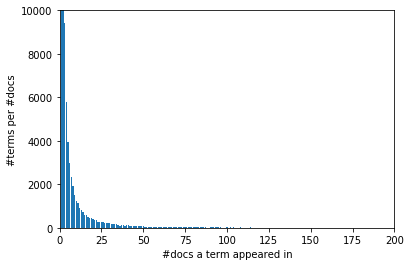

In [42]:
plt.bar(terms_distrib.keys(), terms_distrib.values())
# plt.ylim(0, np.max(list(terms_distrib.values())))
plt.ylim(0, 10000)
# plt.xlim(0, np.max(list(terms_distrib.keys())))
plt.xlim(0, 200)
plt.ylabel ('#terms per #docs')
plt.xlabel ('#docs a term appeared in')


Since it is hard to see the results in the graph because of the big difference in the values, we also print the dict containing the results:

In [43]:
terms_distrib

{1: 77023,
 15: 575,
 2: 18942,
 9: 1525,
 10: 1238,
 8: 1917,
 23: 289,
 11: 1140,
 3: 9397,
 4: 5771,
 7: 2337,
 20: 418,
 19: 434,
 16: 587,
 6: 2990,
 13: 841,
 5: 3936,
 22: 342,
 12: 918,
 18: 432,
 37: 128,
 54: 53,
 14: 726,
 58: 43,
 27: 214,
 28: 208,
 45: 79,
 35: 120,
 21: 362,
 29: 203,
 41: 114,
 26: 244,
 24: 262,
 40: 108,
 30: 198,
 68: 30,
 44: 83,
 32: 164,
 31: 180,
 17: 497,
 25: 254,
 38: 116,
 39: 100,
 43: 96,
 42: 94,
 33: 175,
 127: 7,
 55: 56,
 61: 34,
 53: 53,
 46: 94,
 60: 47,
 91: 23,
 52: 59,
 34: 154,
 146: 4,
 83: 19,
 188: 3,
 48: 68,
 76: 24,
 49: 79,
 135: 5,
 67: 37,
 80: 19,
 59: 47,
 92: 14,
 199: 3,
 115: 6,
 81: 25,
 74: 25,
 185: 4,
 65: 45,
 50: 63,
 99: 12,
 110: 6,
 36: 105,
 75: 26,
 56: 55,
 62: 35,
 126: 8,
 69: 27,
 87: 22,
 121: 10,
 70: 21,
 123: 8,
 63: 41,
 73: 29,
 78: 30,
 114: 16,
 116: 7,
 95: 27,
 64: 41,
 113: 7,
 96: 21,
 85: 21,
 71: 33,
 159: 3,
 100: 16,
 184: 1,
 84: 25,
 51: 59,
 154: 5,
 90: 23,
 82: 26,
 94: 21,
 329: 1

The results show us that there are relatively few words that belong to a large amount of documents, which makes it hard to build a model that will distinguish a category according to a certain word. It means that we need to use several features in order to determine with high accuracy the category of a specific document.

#### 1.5 The expected challenges<br>
As we already saw, there are several words in the top 10 frequent which are occurs in more than one category.<br>
This overlap can interfere the model to learn the difference between the categories and it could be a reason for poor classification results.<br>
To get over this challenge we will try to remove these words from the dataset in order to have better results.
In addition, in the last section we have seen that there are a few words that belong to a large amount of documents which makes it difficult to distinguish a category according to a specific word. Therefore, we need to use several words as features in order to have high accuracy.

### Q2 Document classification<br>
#### NOTE: We have treated the problem not as a multi-label problem since the dataset targets are only one label per document.<Br>This may be a good explanation for the poor prediction results that we will see next...

We will implement a count frequency (countVectorizer) and TF*IDF (TfidfTransformer) as two features extraction by using Pipeline.

In [44]:
X_train = pd.DataFrame([' '.join(sentence) for sentence in stemmed_train])
y_train = pd.DataFrame([str(target) for target in train_data['target']])
X_test = [' '.join(sentence) for sentence in stemmed_test]
y_test = pd.DataFrame([str(target) for target in test_data['target']])

#### 2.1 <br>
For the train part, we will use k-fold validation technique by using our 'train' function.
This function parameters will be: model, X_train , labels, and by default k=6.
We will build a pipeline for features extraction.

In [45]:
############ Some util functinos ############
def show_confusion_matrix(confusion_mat,classes,title = ''):
    range_of_classes = list(range(len(classes)))
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(confusion_mat,cmap='Greens',annot=True,linewidths=1.0, fmt='d',ax=ax)
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.title(title)
    plt.xticks(range_of_classes, classes, rotation=45)
    plt.yticks(range_of_classes, classes,rotation=0)
    plt.show()
    
def flatten(lst):
    return list(map(lambda x:x[0],lst))

def df_to_list(df):
    return flatten(df.values.tolist()) 
#############################################

In [46]:
def build_pipeline(model,ngram_range=(1,1)):
    return Pipeline([
        ('vect', CountVectorizer(ngram_range=ngram_range)),
        ('tfidf', TfidfTransformer()),
        ('model', model)])


def train(model,X_train, y_train, n_folds = 6,ngram_range=(1,1)):
    classes = list(map(str,sorted(map(int,set(y_train.values.reshape(len(y_train),).tolist())))))
    confusion = np.zeros((len(classes),len(classes)),dtype=int)
    k_fold = KFold(n_splits = n_folds)
    pipeline = build_pipeline(model,ngram_range)
    scores = []
    print("Training with %d folds" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold.split(X_train)):
        train_text = flatten(X_train.iloc[train_indices].values.tolist())
        train_y = flatten(y_train.iloc[train_indices].values.tolist())

        test_text = flatten(X_train.iloc[test_indices].values.tolist())
        test_y = flatten(y_train.iloc[test_indices].values.tolist())
        
        print("Training for fold %d" % i)
        pipeline.fit(train_text, train_y)
        print("Testing for fold %d" % i)
        predictions = pipeline.predict(test_text)
        
        confusion += confusion_matrix(test_y, predictions,labels=classes)


        score = accuracy_score(test_y, predictions)
        scores.append(score)
        
        print("Score for %d: %2.2f" % (i, score))
        print("-------------------")

    print('Total corpus classified:', len(X_train))
    print('Score:', round(sum(scores)/len(scores),5))
    show_confusion_matrix(confusion,classes,title="Confusion Matrix")
    return pipeline

#### 2.2 classify
Let's see what the result will be with the LogisticRegression model

Training with 6 folds
Training for fold 0


C:\Users\zvikf\Anaconda3\envs\hebetim\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zvikf\Anaconda3\envs\hebetim\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing for fold 0
Score for 0: 0.33
-------------------
Training for fold 1
Testing for fold 1
Score for 1: 0.34
-------------------
Training for fold 2
Testing for fold 2
Score for 2: 0.33
-------------------
Training for fold 3
Testing for fold 3
Score for 3: 0.34
-------------------
Training for fold 4
Testing for fold 4
Score for 4: 0.32
-------------------
Training for fold 5
Testing for fold 5
Score for 5: 0.34
-------------------
Total corpus classified: 10433
Score: 0.33394


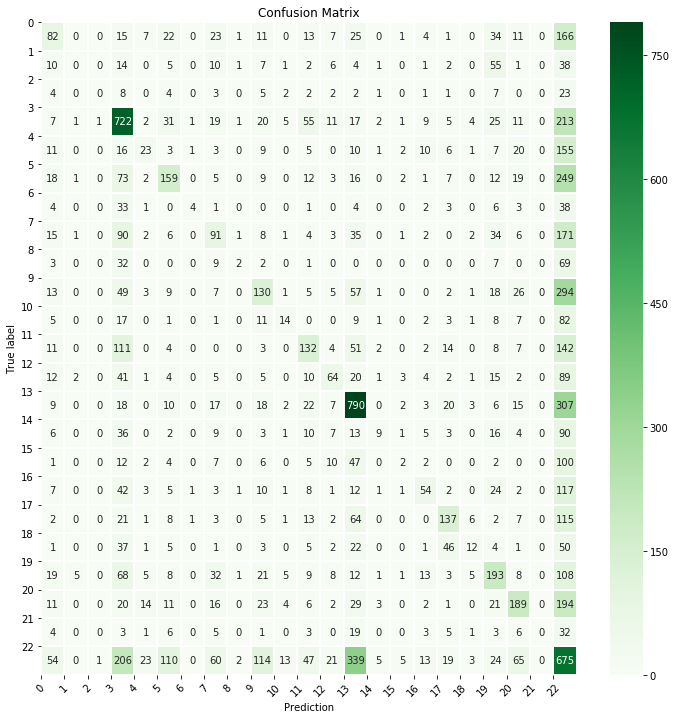

In [47]:
pipeline = train(LogisticRegression(),X_train,y_train)

We can see that the prediction of the categories: Neoplasms, Digestive System Diseases, Nervous System Diseases, Pathological Conditions, Signs and Symptoms is poor because the ratio between the correct predictions and the wrong predictions is low. Because the observation is obious from the table, we won't ellaborate on these details in the next tables.

#### 2.3 Tune and more  pre-processing
hmm, 0.33394 looks pretty bad, in the next cell we will change the defeault parameter penalty='l2' to penalty='l1' based on this article: <br>
https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c 

Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.38
-------------------
Training for fold 1
Testing for fold 1
Score for 1: 0.38
-------------------
Training for fold 2
Testing for fold 2
Score for 2: 0.38
-------------------
Training for fold 3
Testing for fold 3
Score for 3: 0.40
-------------------
Training for fold 4
Testing for fold 4
Score for 4: 0.37
-------------------
Training for fold 5
Testing for fold 5
Score for 5: 0.38
-------------------
Total corpus classified: 10433
Score: 0.38052


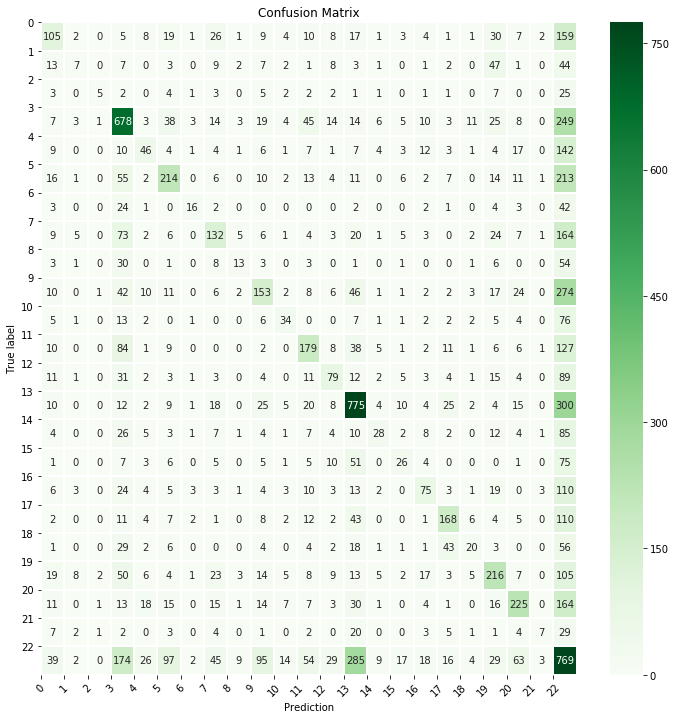

In [48]:
pipeline = train(LogisticRegression(penalty='l1'),X_train,y_train)

Well, this is a nice improvement. We will try to improve it little bit more with taking out the words that's appear in at least two different classes. We called this list of words 'w_c_more_then_2'

In [49]:
def take_out_words(sentence,words):
    return list(filter(lambda word:word not in words,sentence))

new_X_train = pd.DataFrame([' '.join(take_out_words(sentence,w_c_more_then_10.keys())) for sentence in stemmed_train])
new_X_test = [' '.join(take_out_words(sentence,w_c_more_then_10.keys())) for sentence in stemmed_test]


Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.38
-------------------
Training for fold 1
Testing for fold 1
Score for 1: 0.38
-------------------
Training for fold 2
Testing for fold 2
Score for 2: 0.38
-------------------
Training for fold 3
Testing for fold 3
Score for 3: 0.40
-------------------
Training for fold 4
Testing for fold 4
Score for 4: 0.37
-------------------
Training for fold 5
Testing for fold 5
Score for 5: 0.37
-------------------
Total corpus classified: 10433
Score: 0.37976


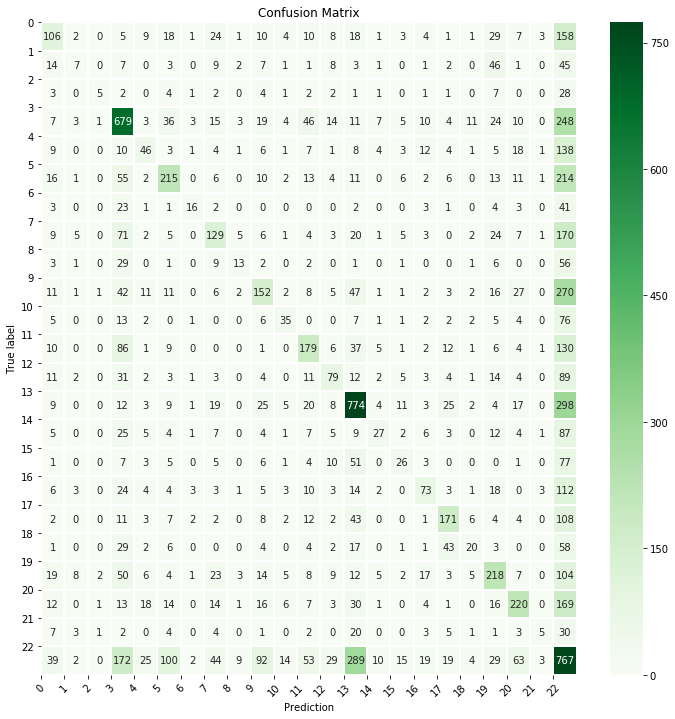

In [50]:
pipeline2 = train(LogisticRegression(penalty='l1'),new_X_train,y_train)

No improvment at all.
So now we will try to use unigram and bigram as parameters for the countVectorizer as a littile bit different feature extraction.

Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.37
-------------------
Training for fold 1
Testing for fold 1
Score for 1: 0.39
-------------------
Training for fold 2
Testing for fold 2
Score for 2: 0.37
-------------------
Training for fold 3
Testing for fold 3
Score for 3: 0.40
-------------------
Training for fold 4
Testing for fold 4
Score for 4: 0.38
-------------------
Training for fold 5
Testing for fold 5
Score for 5: 0.38
-------------------
Total corpus classified: 10433
Score: 0.38148


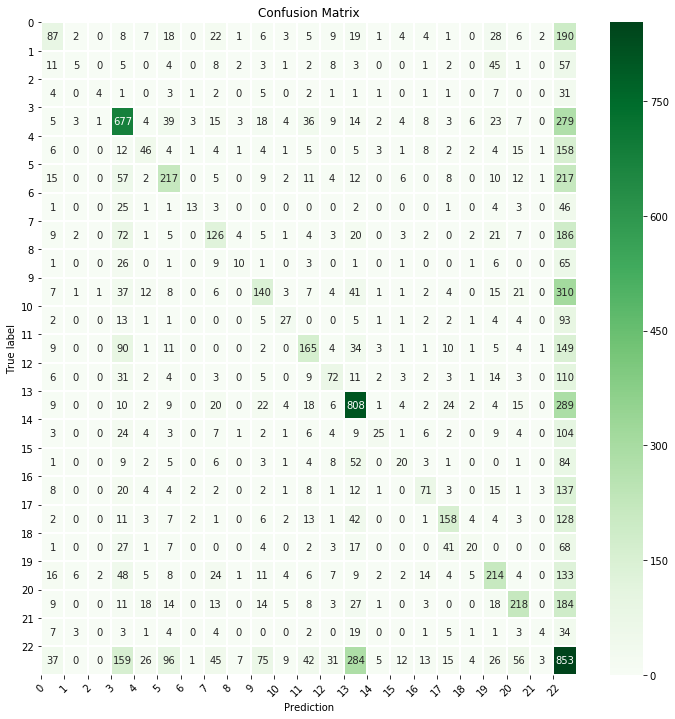

In [51]:
pipeline3 = train(LogisticRegression(penalty='l1'),X_train,y_train,ngram_range=(1,2))

Little bit better.

#### 2.4 
Let's check what are the results on the test

In [52]:
pred = pipeline.predict(X_test)
pred2 = pipeline2.predict(new_X_test) #preprocessed test without top10 frequent words.
pred3 = pipeline3.predict(X_test)

score = accuracy_score(y_test, pred)
score2 = accuracy_score(y_test, pred2)
score3 = accuracy_score(y_test, pred3)

print("Test score without taking out common words: {}".format(score))
print("Test score with taking out common words: {}".format(score2))
print("Test score with uni/bigram parameters for the countVectorizer: {}".format(score3))


Test score without taking out common words: 0.4027330558391581
Test score with taking out common words: 0.40179062279117256
Test score with uni/bigram parameters for the countVectorizer: 0.3995130762585408


Looks like the best model was the first try, LogisticRigression with overlapping words and with unigram as parameter for the CounterVectorizer

#### OK,now let's check what happend if we change the model to Multinomial Naive Bayes.
#### We will repeat 2.2, 2.3, 2,4 sections for the new model.


Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.26
-------------------
Training for fold 1
Testing for fold 1
Score for 1: 0.25
-------------------
Training for fold 2
Testing for fold 2
Score for 2: 0.24
-------------------
Training for fold 3
Testing for fold 3
Score for 3: 0.25
-------------------
Training for fold 4
Testing for fold 4
Score for 4: 0.24
-------------------
Training for fold 5
Testing for fold 5
Score for 5: 0.26
-------------------
Total corpus classified: 10433
Score: 0.25151


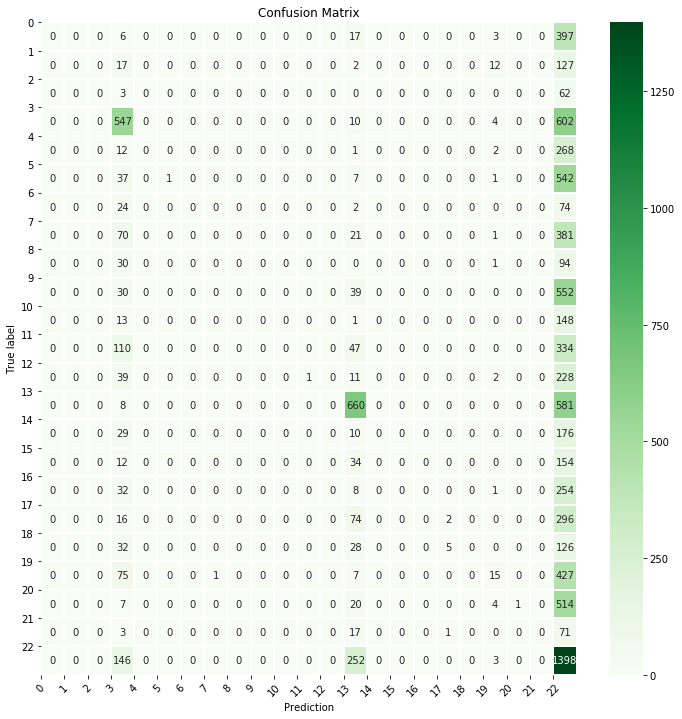

In [53]:
nb_pipeline = train(MultinomialNB(),X_train,y_train)

#### 2.3
Ok, there is intersting parameter in Naive Bayes which called alpha. Alpha is smoothing parameter for words that's never occured in the train dataset before prediction.<br>
Let's see if we can tune this parameter and choose the optimal alpha.<br>
For this mission i will change the train method only by taking out the prints because we are going to call 'train' in a loop for several options of alpha and that's will look messy.

In [54]:
def train2(model,X_train, y_train, n_folds = 6,ngram_range=(1,1)):
    classes = list(map(str,sorted(map(int,set(y_train.values.reshape(len(y_train),).tolist())))))
    confusion = np.zeros((len(classes),len(classes)),dtype=int)
    k_fold = KFold(n_splits = n_folds)
    pipeline = build_pipeline(model,ngram_range)
    scores = []
    for i, (train_indices, test_indices) in enumerate(k_fold.split(X_train)):
        train_text = flatten(X_train.iloc[train_indices].values.tolist())
        train_y = flatten(y_train.iloc[train_indices].values.tolist())

        test_text = flatten(X_train.iloc[test_indices].values.tolist())
        test_y = flatten(y_train.iloc[test_indices].values.tolist())
        
        pipeline.fit(train_text, train_y)
        predictions = pipeline.predict(test_text)
        
        confusion += confusion_matrix(test_y, predictions,labels=classes)
        
        score = accuracy_score(test_y, predictions)
        scores.append(score)

    print('Total corpus classified:', len(X_train))
    score = round(sum(scores)/len(scores),5)
    print('Score:', round(sum(scores)/len(scores),5))
    show_confusion_matrix(confusion,classes,title="Confusion Matrix")

    return pipeline,score

In [55]:
def find_optimal_alpha(alpha_range):
    scores = {}
    for alpha in alpha_range:
        print("alpha {}".format(alpha))
        _,score = train2(MultinomialNB(alpha),X_train,y_train) 
        scores[alpha] = score
    return scores

alpha 0.1
Total corpus classified: 10433
Score: 0.28065


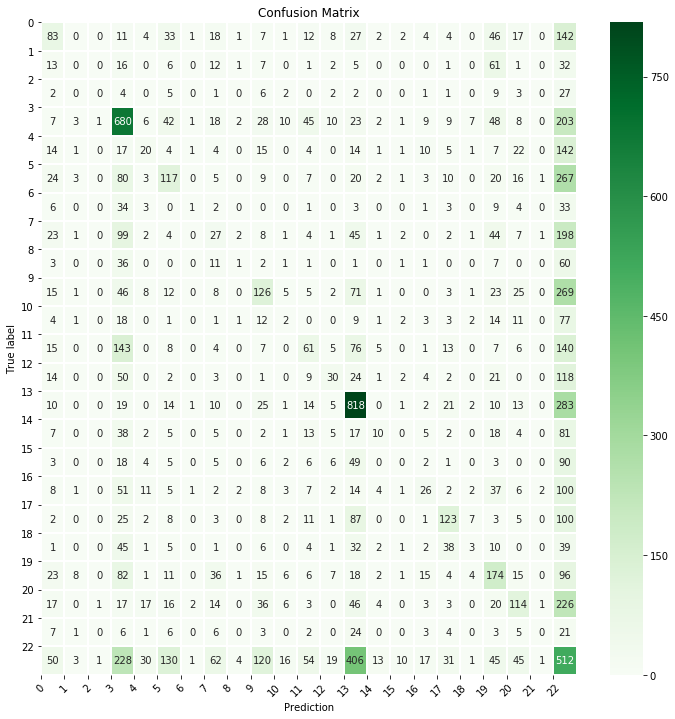

alpha 0.2
Total corpus classified: 10433
Score: 0.27624


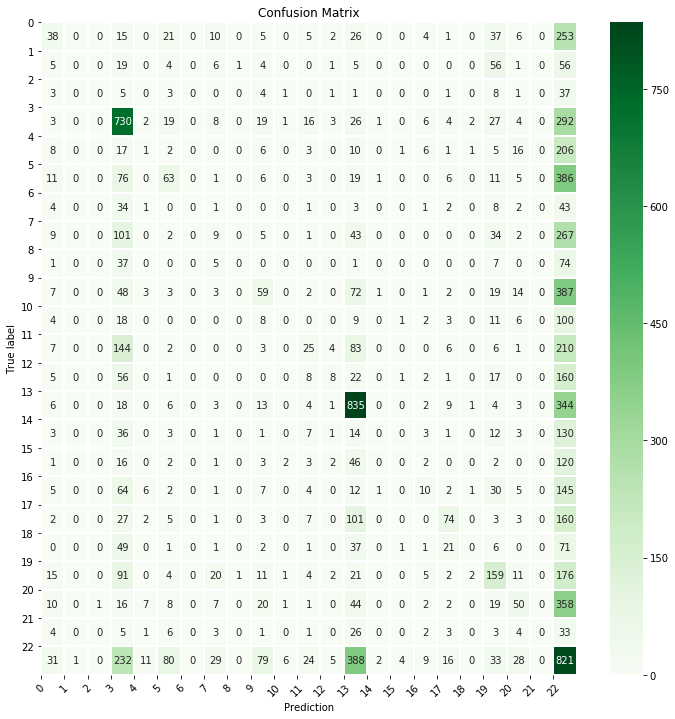

alpha 0.3
Total corpus classified: 10433
Score: 0.2749


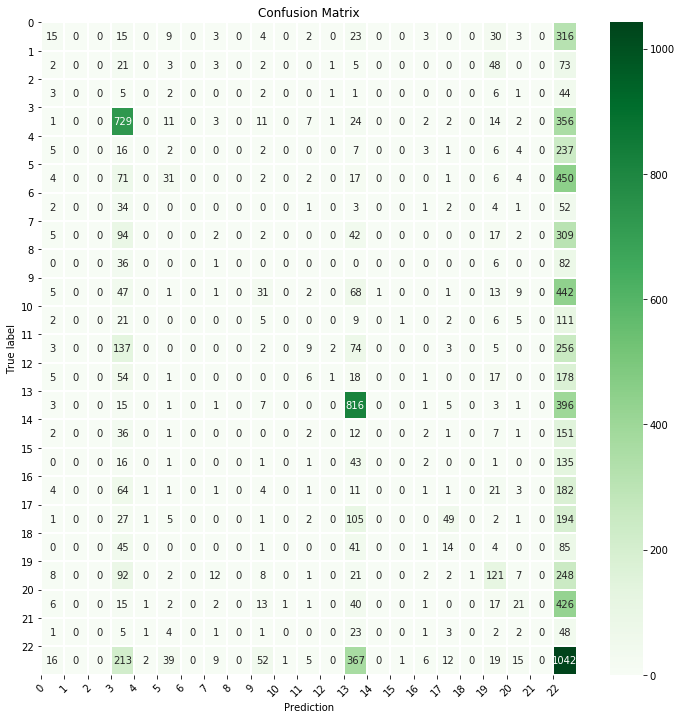

alpha 0.4
Total corpus classified: 10433
Score: 0.27039


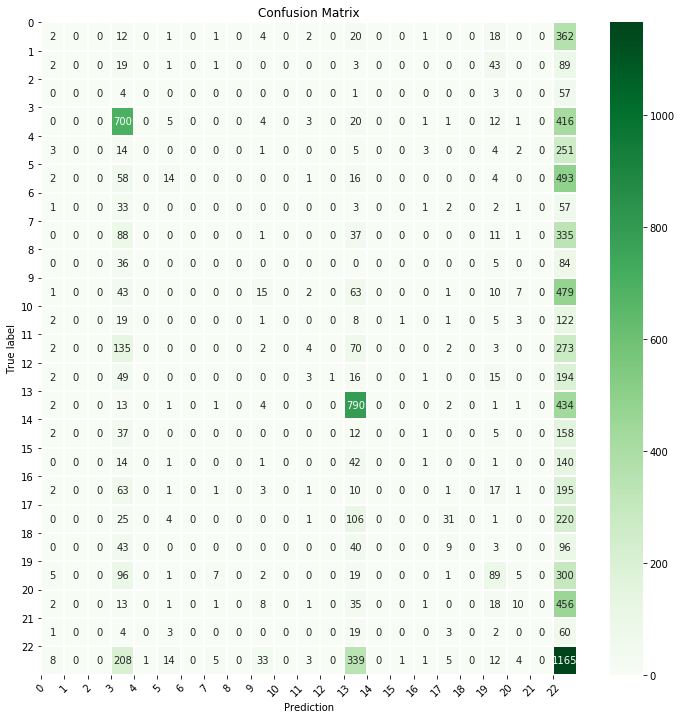

alpha 0.5
Total corpus classified: 10433
Score: 0.2656


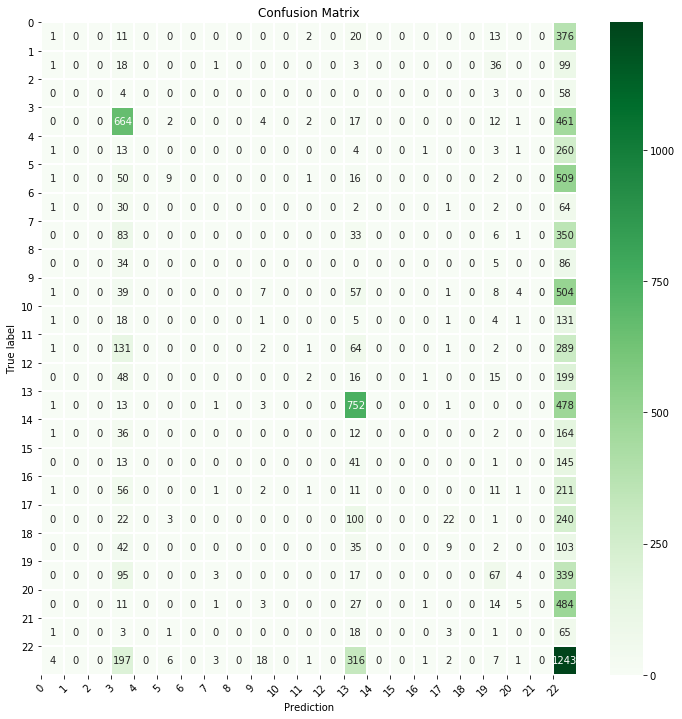

alpha 0.6
Total corpus classified: 10433
Score: 0.26119


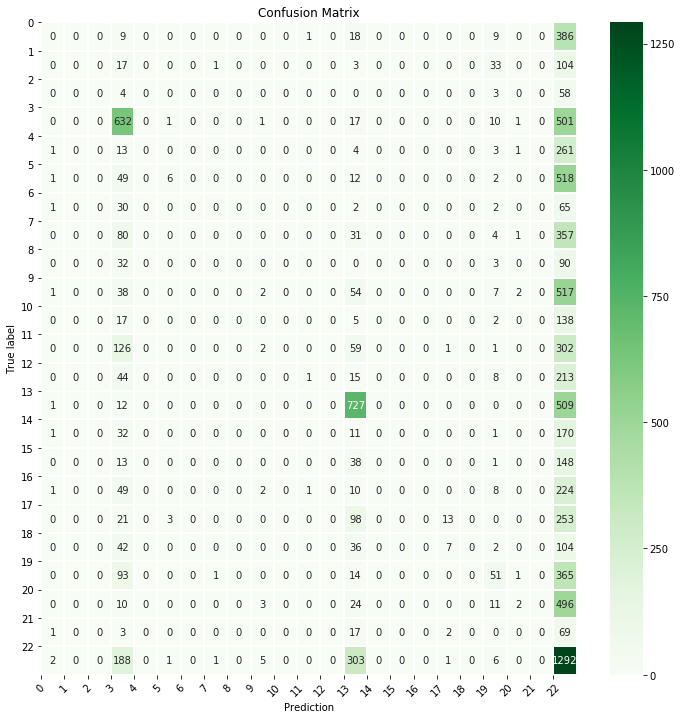

alpha 0.7
Total corpus classified: 10433
Score: 0.25669


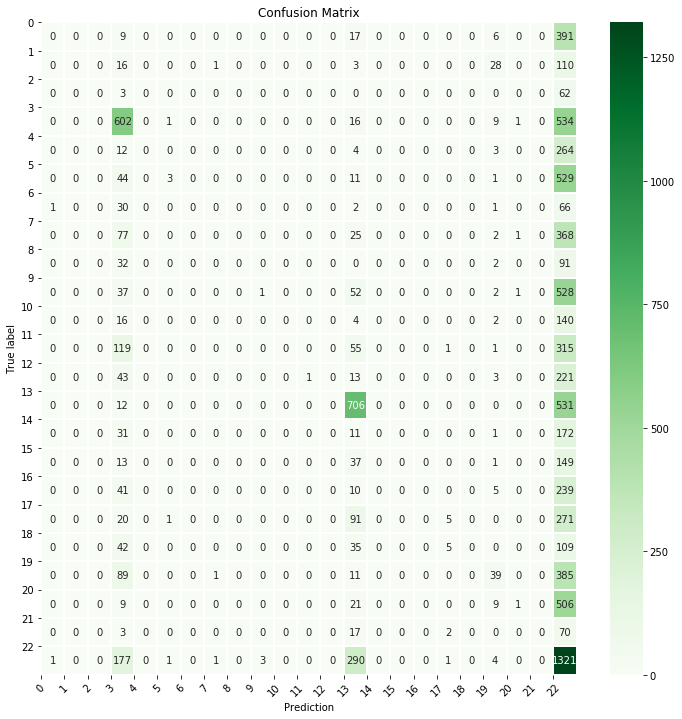

alpha 0.8
Total corpus classified: 10433
Score: 0.25487


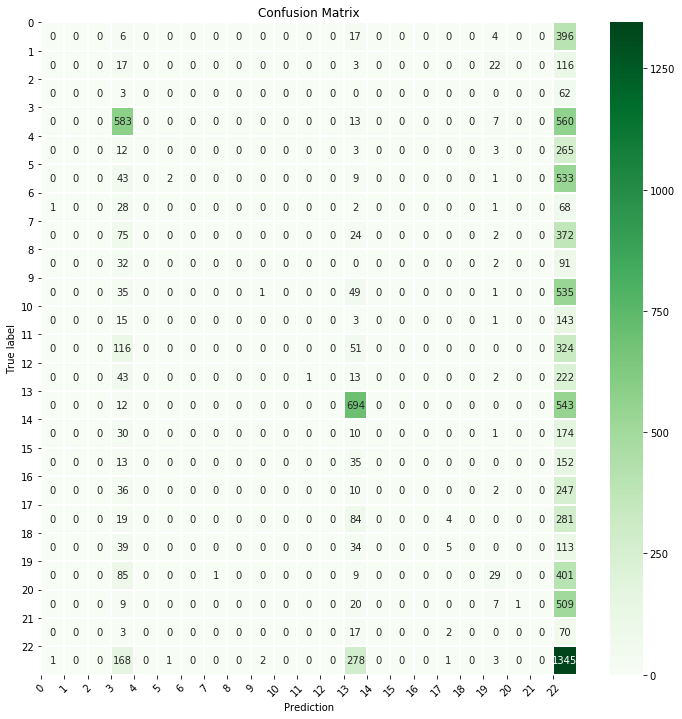

alpha 0.9
Total corpus classified: 10433
Score: 0.25314


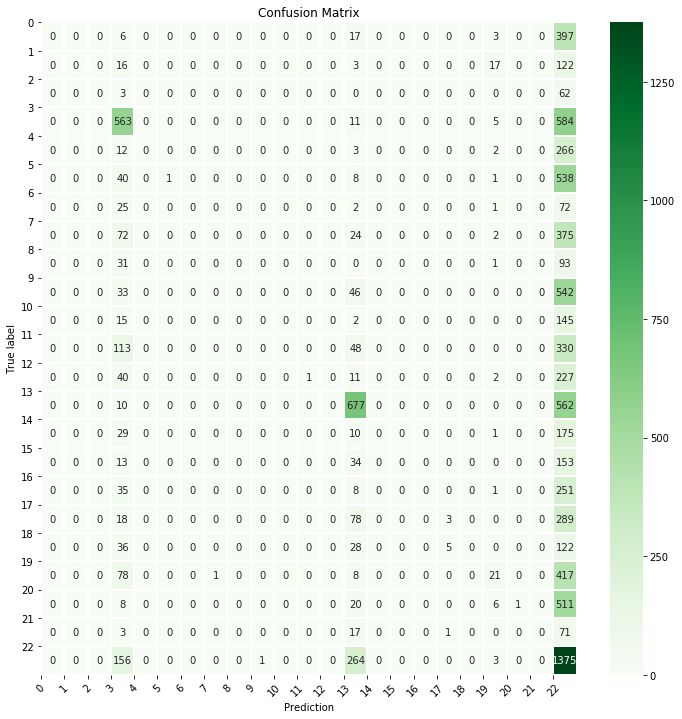

{0.1: 0.28065,
 0.2: 0.27624,
 0.3: 0.2749,
 0.4: 0.27039,
 0.5: 0.2656,
 0.6: 0.26119,
 0.7: 0.25669,
 0.8: 0.25487,
 0.9: 0.25314}

In [56]:
alpha_range = [i/10 for i in range(1,10)]
scores = find_optimal_alpha(alpha_range)
scores

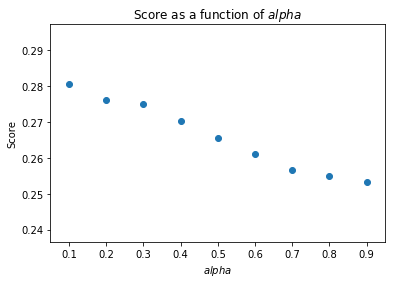

In [57]:
plt.scatter(scores.keys(),scores.values())
plt.xlabel(xlabel='$alpha$')
plt.ylabel(ylabel='Score')
plt.title("Score as a function of $alpha$")
plt.show()

So, the best score is for alpha 0.1 and the score is  0.28065.<br>
Now we will check for the test results.


Total corpus classified: 10433
Score: 0.28065


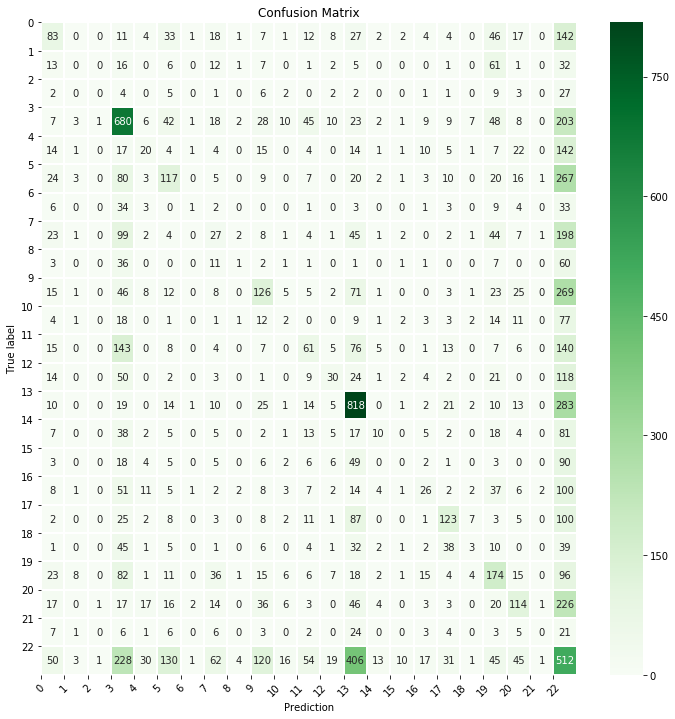

test score 0.35867


In [58]:
nb_pipeline2,_ = train2(MultinomialNB(alpha=0.1),X_train,y_train) 
pred = nb_pipeline2.predict(X_test)
score = accuracy_score(y_test, pred)
print("test score {}".format(round(score,5)))

0.35867 looks better.<br>
Now, lets see how the same pre process of taking out common words we have tried before is affecting this model score.

Total corpus classified: 10433
Score: 0.2795


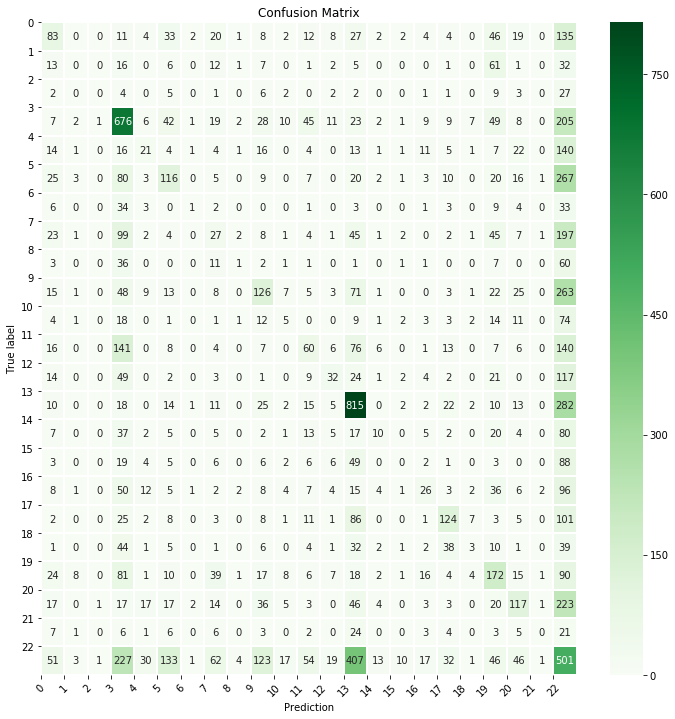

In [59]:
nb_pipeline3,_ = train2(MultinomialNB(alpha=0.1),new_X_train,y_train) 


Not better at all, how it will affect the test results? 

In [60]:
pred = nb_pipeline3.predict(new_X_test)
score = accuracy_score(y_test, pred)
print("test score after preprocess {}".format(round(score,5)))

test score after preprocess 0.36056


Yep, it did improved a little bit.
Now, let's see what happend if we change the feature countVectorizer to use bigrams as well

Total corpus classified: 10433
Score: 0.16151


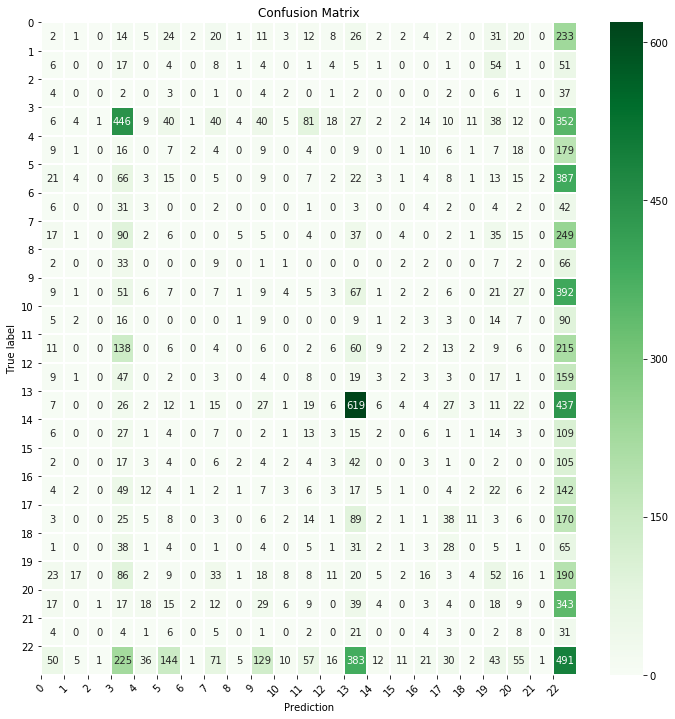

In [61]:
nb_pipeline4,_ = train2(MultinomialNB(alpha=0.1),new_X_train,y_train,ngram_range=(1,2)) 


Much worse results, maybe the probability to "see" the bi-grams from the train in the val is lower then to see the unigrams and that's affect the results.

In [62]:
pred2 = nb_pipeline2.predict(new_X_test) #preprocessed test without top10 frequent words.
pred3 = nb_pipeline3.predict(X_test)
pred4 = nb_pipeline4.predict(X_test)

score2 = accuracy_score(y_test, pred2)
score3 = accuracy_score(y_test, pred3)
score4 = accuracy_score(y_test, pred4)

print("Test score without taking out common words: {}".format(score2))
print("Test score with taking out common words: {}".format(score3))
print("Test score with uni/bigram parameters for the countVectorizer: {}".format(score4))


Test score without taking out common words: 0.36134453781512604
Test score with taking out common words: 0.35262703212125973
Test score with uni/bigram parameters for the countVectorizer: 0.2810806565616901


#### 2.4 + 2.5 Conclusions :
1. Best score of Logistic Regression experiments vs best score of Naive Bayes on validation data: 0.38148 vs 0.28065
2. We can see the better results expressed in the confusion matrix along the improvements.
3. Best score of Logistic regression vs best score of Naive Bayes on test data: 0.4027.. vs  0.3613..
4. We will talk about the challenges for both models in the summary 

#### 2.5 - Summary

We will describe the task challenges, and explain effective solutions
The task was to classify documents to type of diseases which appeard to be a multi-label problem.
We tested two models. Logistic Regression and Naive Bayes.
<br>
<br>
We have tried to improve the two models by several ways:
>1. At the first try, we just used countVectorizer+tfidfTransformer as feature extraction.
>2. Then, we have tried to remove the "confusing" words which are overlap over the different categories documents, actully we removed the words which appear at least in n = 10 differents categories, after we tried several options for n (2,5,10,20) which was the best results of n options but at the end, didn't improve our first try at all.
>3. After the last one we tought to improve the results with unigram+bigram as features what appeared to improve the results a little bit.
>4. For the Naive Bayes we also tried to find optimal alpha parameter by using the validation data, which you can see in the plot in the relevant cell above.

The biggest challange was to pass the 40% accuracy. We think that one of the reasons for the poor results is that we have used two models and dataset that are didn't fit the multi-label task. <br>
The dataset didn't fit because the targets are only one label for each document. To answer to this problem we were needed to transform the dataset to pairs of $(document_i,listOfLabels_i)$ and then to train relevant model for the problem.<br>
Another thing that didn't improve the results was to remove the overlapping words which may cause to 'confusions' in the training period.<br>
Another interesting improvment which we could try is to use is lemmatizig instead of stemming in the pre-process section.<br>
Stemming algorithms work by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found in an inflected word. This indiscriminate cutting can be successful in some occasions, but not always, and that is why we affirm that this approach presents some limitations.
Lemmatization, on the other hand, takes into consideration the morphological analysis of the words to do so, it is necessary to have detailed dictionaries which the algorithm can look through to link the form back to its lemma.<br>
Another interesting insight is that the best predicted categories according to most of the confusion matrixs were  category: 14 (Cardiovascular Diseases) and category: 23 (Pathological Conditions, Signs and Symptoms).<br>
We think that the reason is that this categoires are the tallest bins in the first histogram, the meaning is that for this two categories we have a big amount of document to train on.<br>
The best results are for the Logistic Regression with counterVectorizer+TFIDF pipeline using only unigrams and no removed words at all.<br>
We hope you enjoyed our notebook :)
